# 4.Identification of spatial variable genes and archetypes

This notebook demonstrates how to use spateo to identify spatial variable genes, by calculating 
Moran‘s I score, and how to get spatial gene archetypes.

In [1]:
import spateo as st

import numpy as np

st.configuration.set_pub_style_mpltex()
%matplotlib inline

2022-11-13 20:18:33.040154: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
network.py (36): The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.


## Data source
**bin60_clustered_h5ad:** https://www.dropbox.com/s/wxgkim87uhpaz1c/mousebrain_bin60_clustered.h5ad?dl=0

In [2]:
# Load annotated binning data
fname_bin60 = "mousebrain_bin60_clustered.h5ad"
adata_bin60 = st.sample_data.mousebrain(fname_bin60)

adata_bin60

AnnData object with n_obs × n_vars = 7765 × 21667
    obs: 'area', 'n_counts', 'Size_Factor', 'initial_cell_size', 'louvain', 'scc', 'scc_anno'
    var: 'pass_basic_filter'
    uns: '__type', 'louvain', 'louvain_colors', 'neighbors', 'pp', 'scc', 'scc_anno_colors', 'scc_colors', 'spatial', 'spatial_neighbors'
    obsm: 'X_pca', 'X_spatial', 'bbox', 'contour', 'spatial'
    layers: 'count', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

## SVG identification (Moran's I)

In [3]:
# Filter out low expressed and uninterested, such as mitochondrial genes
mito_genes = adata_bin60.var_names.str.startswith("mt-")
adata_bin60 = adata_bin60[: ,~mito_genes]

st.pp.filter.filter_genes(adata_bin60,min_cells= adata_bin60.n_obs*0.05, inplace=True)
adata_bin60

AnnData object with n_obs × n_vars = 7765 × 5059
    obs: 'area', 'n_counts', 'Size_Factor', 'initial_cell_size', 'louvain', 'scc', 'scc_anno'
    var: 'pass_basic_filter'
    uns: '__type', 'louvain', 'louvain_colors', 'neighbors', 'pp', 'scc', 'scc_anno_colors', 'scc_colors', 'spatial', 'spatial_neighbors'
    obsm: 'X_pca', 'X_spatial', 'bbox', 'contour', 'spatial'
    layers: 'count', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [ ]:
# Calculate Moran's I score for genes
m = st.tl.moran_i(adata_bin60, n_jobs=30)

In [5]:
# Filter genes by Moran's I score and adjusted p-value
m_filter = m[(m.moran_i > 0.15)&(m.moran_q_val<0.05)].sort_values(by=['moran_i'],ascending=False)
m_filter[0:10]

,moran_i,moran_p_val,moran_z,moran_q_val
Plp1,0.529320,0.005,78.720267,0.014116
Gm28928,0.516217,0.005,72.395455,0.014116
Ntng1,0.511843,0.005,72.667184,0.014116
Mbp,0.510432,0.005,77.079408,0.014116
Gm42418,0.468743,0.005,69.624860,0.014116
Phactr1,0.468161,0.005,70.079342,0.014116
Mobp,0.457718,0.005,61.732588,0.014116
Cmss1,0.436734,0.005,65.651464,0.014116
Kcnip4,0.421696,0.005,61.525662,0.014116
Camk1d,0.406778,0.005,56.055133,0.014116


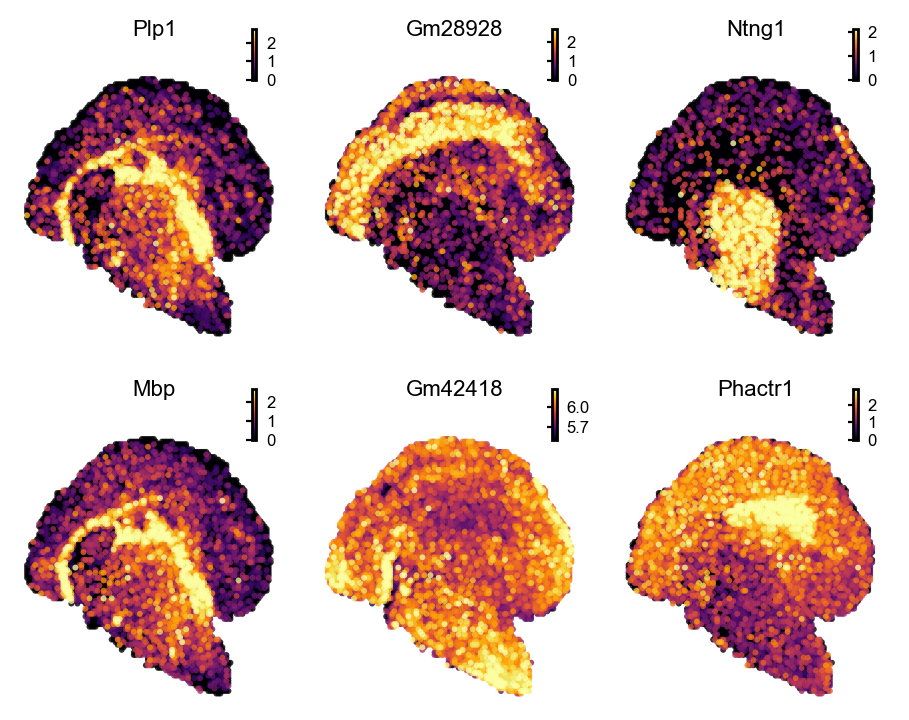

In [6]:
# Visualize top SVGs
st.pl.space(
    adata_bin60,
    genes=m_filter.index[0:6].tolist(),
    pointsize=0.1,
    ncols=3,
    show_legend="upper left",
    figsize=(2,2),
)

## SVG archetypes

In [7]:
# Cluster identified SVGs into archetypes
num_clusters = 15

archetypes, clusters, gene_corrs = st.tl.find_spatial_archetypes(
    exp_mat = adata_bin60[:,m_filter.index].X.A.T,
    num_clusters = num_clusters,
)

|-----> [Finding gene archetypes] in progress: 100.0000%
|-----> [Finding gene archetypes] finished [0.1889s]
|-----> done!


In [8]:
# Create dataframe with genes and its archetype
df_clusters = pd.DataFrame({"gene":m_filter.index.to_list(), "archetype":clusters-1})
df_clusters[0:10]

# Save gene cluster info
# df_clusters.to_csv("archetype_clusters.csv")

,gene,archetype
0,Plp1,11
1,Gm28928,14
2,Ntng1,8
3,Mbp,11
4,Gm42418,2
5,Phactr1,5
6,Mobp,11
7,Cmss1,1
8,Kcnip4,4
9,Camk1d,1


In [9]:
# Calculate genes having significant spatial correlation with each archetype
archetypes_dict = st.tl.archetypes_genes(
    adata=adata_bin60,
    archetypes=archetypes,
    num_clusters=num_clusters,
    moran_i_genes=m_filter.index,
)

|-----? No genes with significant correlation were found at the current p-value threshold.


In [10]:
# Calculate expression scores for archetypes
adata_bin60.obs = st.tl.archetypes(adata_bin60,m_filter.index,num_clusters=num_clusters)

|-----> [Finding gene archetypes] in progress: 100.0000%
|-----> [Finding gene archetypes] finished [0.1891s]
|-----> done!


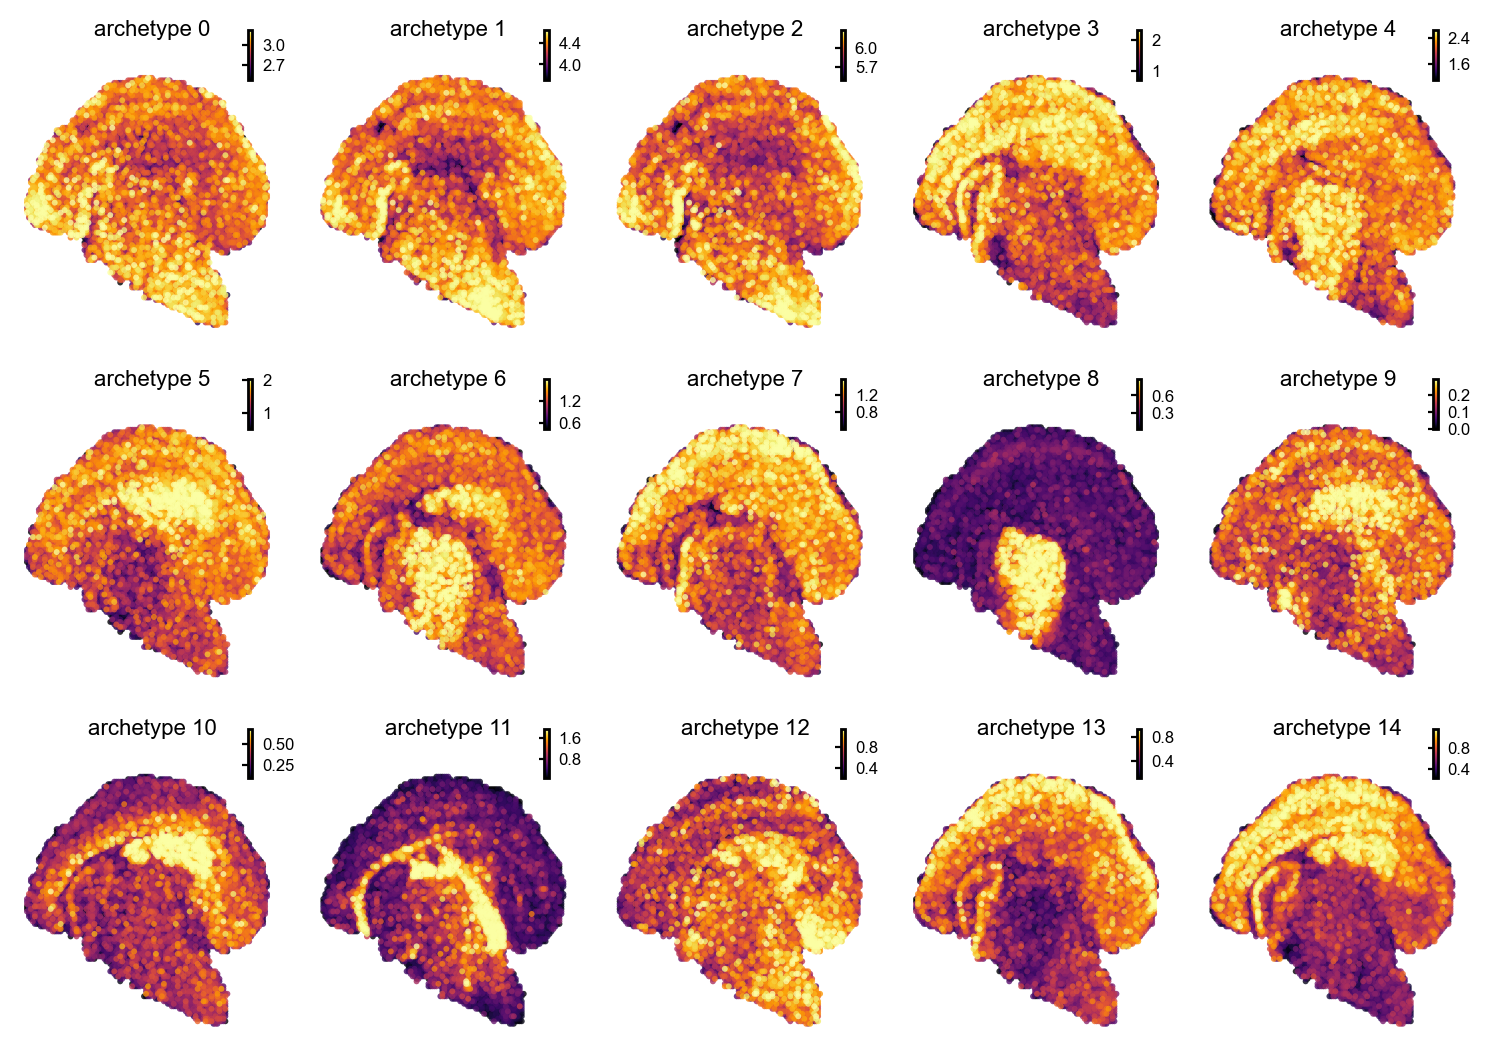

In [11]:
# Visualize archetypes
arch_cols = ["archetype %d" % i for i in np.arange(num_clusters)]
st.pl.space(
    adata_bin60,
    color = adata_bin60.obs[arch_cols].columns.tolist(),
    pointsize=0.1,
    ncols=5,
    show_legend="upper left",
    figsize=(2,2),
)